In [73]:
#Importing neccessary files for covid prediction
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [74]:
# we have loaded the dataset within the keras default directory and used that location to load the dataset
import pathlib

data_dir = tf.keras.utils.get_file('CN_Images',origin='http://localhost:8888/tree/Downloads/project123/TRAIN')
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('C:/Users/mahaj/.keras/datasets/CN_Images')

In [75]:
# counting the jpg images. dataset contains both png as well as jpg images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

202


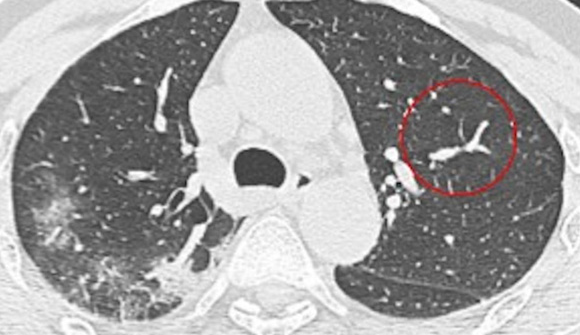

In [76]:
# printing images from covid dataset and printing first image
Covid = list(data_dir.glob('Covid/*'))
PIL.Image.open(str(Covid[0]))

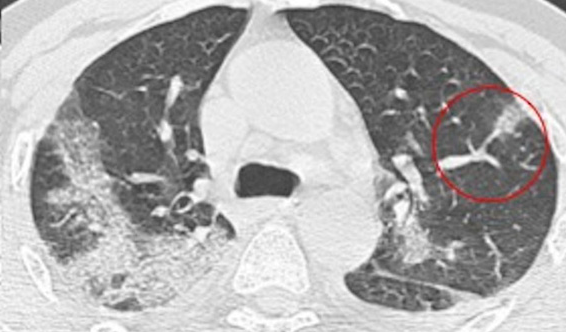

In [77]:
# Printing first image from covid dataset
PIL.Image.open(str(Covid[1]))

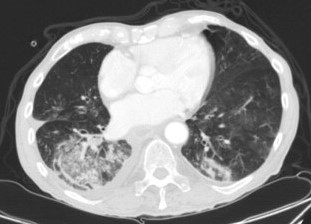

In [78]:
# Printing images from non-covid dataset
NCovid = list(data_dir.glob('Non_Covid/*'))
PIL.Image.open(str(NCovid[0]))

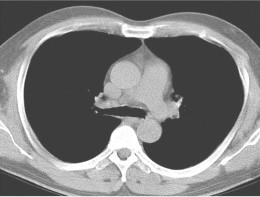

In [79]:
# Printing non-dataset image 1 
PIL.Image.open(str(NCovid[1]))

In [80]:
# setting the image sizes and along with batch size
batch_size = 20
img_height = 200
img_width = 200

In [81]:
# obtaining training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 746 files belonging to 2 classes.
Using 597 files for training.


In [82]:
# Obtaining validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 746 files belonging to 2 classes.
Using 149 files for validation.


In [83]:
# Obtaining classes 
class_names = train_ds.class_names
print(class_names)

['COVID', 'Non_COVID']


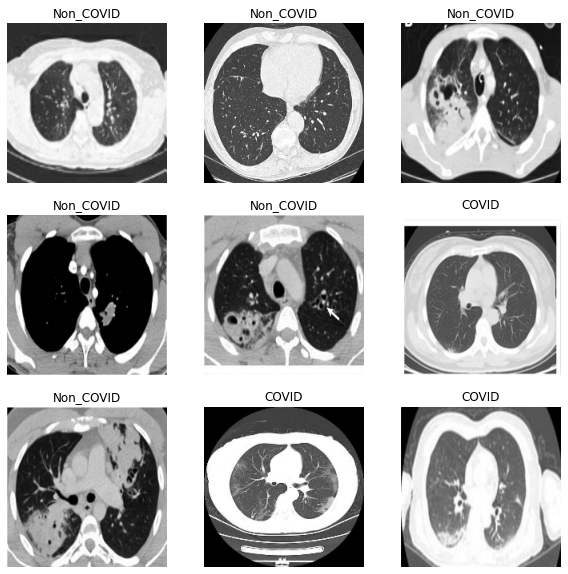

In [84]:
# Ploting images from the dataset according to the classes
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [85]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(20, 200, 200, 3)
(20,)


In [86]:
# Autotuning for best possible performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [87]:
# performing normalization layer
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [88]:
# performing normalization
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [89]:
# defining model
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [90]:
# Compiling model for checking accuracy of model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [91]:
# prinitng model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 64)       

In [92]:
# defining iterations in terms of epochs and fitting the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
30/30 [==============================] - 10s 322ms/step - loss: 0.8675 - accuracy: 0.5494 - val_loss: 0.5881 - val_accuracy: 0.6846
Epoch 2/10
30/30 [==============================] - 9s 315ms/step - loss: 0.5986 - accuracy: 0.6935 - val_loss: 0.4745 - val_accuracy: 0.7651
Epoch 3/10
30/30 [==============================] - 10s 318ms/step - loss: 0.5097 - accuracy: 0.7454 - val_loss: 0.4737 - val_accuracy: 0.7718
Epoch 4/10
30/30 [==============================] - 10s 319ms/step - loss: 0.4176 - accuracy: 0.8074 - val_loss: 0.4689 - val_accuracy: 0.7785
Epoch 5/10
30/30 [==============================] - 10s 320ms/step - loss: 0.3482 - accuracy: 0.8275 - val_loss: 0.4612 - val_accuracy: 0.7919
Epoch 6/10
30/30 [==============================] - 10s 321ms/step - loss: 0.2534 - accuracy: 0.8978 - val_loss: 0.4556 - val_accuracy: 0.8054
Epoch 7/10
30/30 [==============================] - 10s 321ms/step - loss: 0.1619 - accuracy: 0.9430 - val_loss: 0.5101 - val_accuracy: 0.8188


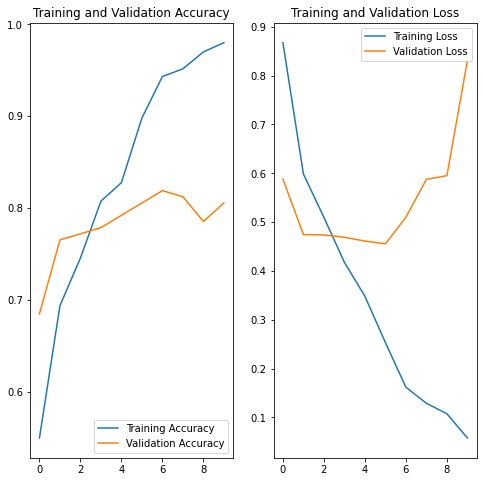

In [93]:
# Ploting validation and training accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [99]:
# Fine tuning the model

model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 5

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  10


In [100]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [101]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 64)       

In [102]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=total_epochs
)

Epoch 1/20
30/30 [==============================] - 17s 224ms/step - loss: 0.1418 - accuracy: 0.9531 - val_loss: 0.7959 - val_accuracy: 0.7785
Epoch 2/20
30/30 [==============================] - 5s 151ms/step - loss: 0.0271 - accuracy: 1.0000 - val_loss: 0.8318 - val_accuracy: 0.7785
Epoch 3/20
30/30 [==============================] - 5s 161ms/step - loss: 0.0115 - accuracy: 0.9983 - val_loss: 0.8778 - val_accuracy: 0.7987
Epoch 4/20
30/30 [==============================] - 4s 150ms/step - loss: 0.0072 - accuracy: 0.9983 - val_loss: 0.9362 - val_accuracy: 0.8054
Epoch 5/20
30/30 [==============================] - 4s 148ms/step - loss: 0.0086 - accuracy: 0.9966 - val_loss: 1.0120 - val_accuracy: 0.7852
Epoch 6/20
30/30 [==============================] - 4s 148ms/step - loss: 0.0125 - accuracy: 0.9966 - val_loss: 1.0011 - val_accuracy: 0.7852
Epoch 7/20
30/30 [==============================] - 5s 157ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.0942 - val_accuracy: 0.7919
Epoch

In [103]:
# Printing the result after testing
test_image = tf.keras.utils.get_file('Test_Images/0.jpg',origin='Test_Images/0.jpg')

img = keras.preprocessing.image.load_img(
    test_image, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Non_COVID with a 100.00 percent confidence.
